<p style = "color:#e5ffe5; background:#680e19; text-align:center; font-size:18px; font-weight:600 ">  
    Versions
</p>
<ul>
<li>Python 3.11.8</li>
<li>gymnasium 0.29.1</li>
<li>numpy 1.26.4</li>
<li>pandas 2.2.1</li>
<li>matplotlib 3.8.3</li>
<li>stable_baselines3 2.3.0</li>

</ul>




In [5]:
# Check your versions in case of problems.
import sys
import pkg_resources as pkg
print("Python", sys.version)
print("gymnasium", pkg.get_distribution("gymnasium").version)
print("numpy", pkg.get_distribution("numpy").version)
print("pandas", pkg.get_distribution("pandas").version)
print("matplotlib", pkg.get_distribution("matplotlib").version)
print("stable_baselines3", pkg.get_distribution("stable_baselines3").version)

Python 3.11.8 (tags/v3.11.8:db85d51, Feb  6 2024, 22:03:32) [MSC v.1937 64 bit (AMD64)]
gymnasium 1.0.0
numpy 2.0.2
pandas 2.2.3
matplotlib 3.10.0
stable_baselines3 2.5.0


<p style = "color:#e5ffe5; background:#680e19; text-align:center; font-size:18px; font-weight:600 ">  
    Libraries
</p>

In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import time
import os
import glob
import pickle

from stable_baselines3 import PPO
from stable_baselines3 import A2C
from stable_baselines3 import DDPG

<p style = "color:#e5ffe5; background:#680e19; text-align:center; font-size:18px; font-weight:600 ">  
    Make Environment and Select Model (Algorithm)
</p>

<p>The overall investment limitations are the following:</p>
<ul>
    <li>70% of the fund can be invested in stocks</li>
    <li> 30% of the fund can be invested in fixed income</li>
    <li>7% of the fund can be invested in unlisted real estate</li>
    <li>2% of the fund can be invested in unlisted infrastructure for renewable energy</li>
</ul>
<p>
We have no real data on the last asset class, we leave it out, but we replace it with bills.<br>
I.e. we use the following order: stocks, bonds, bills, housing<br>
Accordngly, we use the same maximum for bills and bonds<br>
This means the maximum weights are: [0.7, 0.3, 0.3, 0.07]<br>
The returns are: [0.1297, 0.0730, 0.0539, 0.1227]<br>
The standard deviations are: [0.2503, 0.0981, 0.0403, 0.1014]
</p>




In [8]:
# Parameters not to be scaled
initial_wealth = 1000

Num_Assets = 4

# Minimum shares of the assets
min_share = [0.001] * Num_Assets
min_share = np.array(min_share)

# Minimum shares of the assets
max_share = [0.7, 0.3, 0.3, 0.07]
max_share = np.array(max_share)

# Utility function parameters
gamma_01 = 6
gamma_02 = 2

# Parameters to be scaled
initial_habit = 0.03 * initial_wealth
lifetime = 100
min_consume_rate = 0.005
max_consume_rate = 0.10
habit_growth = 0.019

# Mean returns of assets
return_mean = np.array([0.1297, 0.0730, 0.0539, 0.1227])

# Standard deviations of assets
return_stdev = np.array([0.2503, 0.0981, 0.0403, 0.1014])

# Correlations of the assets
correlations = np.array([[1.0, 0.0, 0.0, 0.0],
                         [0.0, 1.0, 0.0, 0.0],
                         [0.0, 0.0, 1.0, 0.0],
                         [0.0, 0.0, 0.0, 1.0]])

# Time steps or intervals per year
intervals_per_year = 12

In [11]:
# import Environment_4_Assets_Habit as Env
from Environment_4_Assets_Habit import Env_4_Assets_Habit as Env
# C:\Users\Jakob\OneDrive\Dokumenter\Masteroppgave\BBAN5000-Master-Thesis\SupervisorMaterial\Environment_4_Assets_Habit.py

env = Env(initial_wealth = initial_wealth,
          initial_habit = initial_habit / intervals_per_year,
          lifetime = lifetime * intervals_per_year, 
          min_consume_rate = min_consume_rate / intervals_per_year,
          max_consume_rate = max_consume_rate  / intervals_per_year,
          Num_Assets = Num_Assets,
          min_share = min_share,
          max_share = max_share,
          return_mean = return_mean / intervals_per_year,
          return_stdev = return_stdev / intervals_per_year,
          correlations = correlations,
          gamma_01 = gamma_01,
          gamma_02 = gamma_02,
          habit_growth = habit_growth / intervals_per_year)

Correlation
[[1. 0. 0. 0.]
 [0. 1. 0. 0.]
 [0. 0. 1. 0.]
 [0. 0. 0. 1.]]
Covariances
[[4.35070069e-04 0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 6.68306250e-05 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.12784028e-05 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 7.14025000e-05]]
Cholesky
[[0.02085833 0.         0.         0.        ]
 [0.         0.008175   0.         0.        ]
 [0.         0.         0.00335833 0.        ]
 [0.         0.         0.         0.00845   ]]


<p style = "color:#e5ffe5; background:#680e19; text-align:center; font-size:18px; font-weight:600 ">  
    Testing
</p>

In [12]:
state, info = env.reset()
print(state)
print(info)

[1000]
{'Time': 0, 'Asset Shares': 'n.a.', 'Asset Returns': 'n.a.', 'Rate of Consumption': 'n.a.', 'Wealth_Out': 1000, 'Habit_Out': 2.5, 'Consumption': 0, 'Utility': 0}


In [13]:
# Take random action from action space - These actions are not yet normalized
action = env.action_space.sample()
print(np.array(action))

[0.01420396 0.14548492 0.12276413 0.06010222 0.00191291]


In [16]:
env.action_space.high

array([0.7       , 0.3       , 0.3       , 0.07      , 0.00833333])

In [17]:
env.action_space.low

array([0.001     , 0.001     , 0.001     , 0.001     , 0.00041667])

<p style = "color:#e5ffe5; background:#680e19; text-align:center; font-size:18px; font-weight:600 ">  
    Take random action
</p>

In [18]:
# Take random action from action space
action = env.action_space.sample()
print('Non_normalized Action taken', action)
state, reward, done, somth, info = env.step(action)
print('New state:', state)
print(info)

Non_normalized Action taken [0.34329252 0.18021721 0.18044565 0.02451182 0.00267378]
New state: [984.23357568]
{'Time': 1, 'Asset Shares': array([0.47125322, 0.24739235, 0.24770594, 0.03364849]), 'Asset Returns': array([-0.02839154, -0.00212152,  0.0029796 ,  0.00219161]), 'Rate of Consumption': np.float64(0.0026737812100322378), 'Wealth_Out': np.float64(984.2335756774552), 'Habit_Out': 2.5039583333333333, 'Consumption': np.float64(2.673781210032238), 'Utility': np.float64(0.06499455130442122)}


<p style = "color:#e5ffe5; background:#680e19; text-align:center; font-size:18px; font-weight:600 ">  
    Take fixed action
</p>

In [34]:
state, info = env.reset()
print(state)
print(info)

[1000]
{'Time': 0, 'Asset Shares': 'n.a.', 'Asset Returns': 'n.a.', 'Rate of Consumption': 'n.a.', 'Wealth_Out': 1000, 'Habit_Out': 2.5, 'Consumption': 0, 'Utility': 0}


In [35]:
action = (0.1, 0.2, 0.3, 0.4, 0.003)

In [36]:
state, reward, done, somth, info = env.step(action)
print(info)

{'Time': 1, 'Asset Shares': array([0.1, 0.2, 0.3, 0.4]), 'Asset Returns': array([0.03603751, 0.00896407, 0.00731565, 0.01342391]), 'Rate of Consumption': 0.003, 'Wealth_Out': 1009.9608218868244, 'Habit_Out': 2.5039583333333333, 'Consumption': 3.0, 'Utility': 0.16666666666666663}


<p style = "color:#e5ffe5; background:#680e19; text-align:center; font-size:18px; font-weight:600 ">  
    Run a whole episode
</p>

In [37]:
# Reset
state, info = env.reset()
done = False

# Decision
action = (0.1, 0.2, 0.3, 0.4, 0.003)

Wealth = []
# Run whole episode
while not done:
    state, reward, done, somth, info = env.step(action)
    Wealth.append(state)


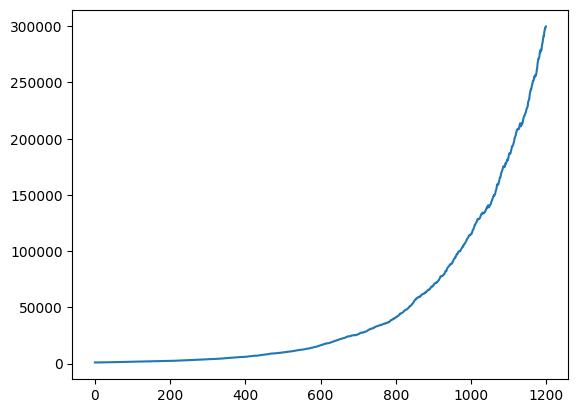

In [38]:
plt.plot(Wealth)

In [17]:
print(info)

{'Time': 1200, 'Asset Shares': array([0.1, 0.2, 0.3, 0.4]), 'Asset Returns': array([-0.0041174 , -0.0112942 ,  0.00405329, -0.00117814]), 'Rate of Consumption': 0.003, 'Wealth_Out': 233894.21417978182, 'Habit_Out': 16.689639723235903, 'Consumption': 705.1561349007867, 'Utility': 0.9763694089727477}


<p style = "color:#e5ffe5; background:#680e19; text-align:center; font-size:18px; font-weight:600 ">  
    General folder
</p>

In [40]:
# All models will be saved in the following folder
folder_name = 'Experiment_007'

<p style = "color:#000000; background:#ffd43b; text-align:center; font-size:18px; font-weight:600 ">  
    A2C
</p>

<p style = "color:#e5ffe5; background:#680e19; text-align:center; font-size:18px; font-weight:600 ">  
    Select Model and Model Parameters
</p>

In [41]:
learn_alg  = A2C

# The model name is used to create a subfolder where all the models
# and tensorboard files will be saved
model_name = folder_name + '/' + learn_alg.__name__
print('Everything will be saved in:', model_name)




Everything will be saved in: Experiment_007/A2C


In [44]:
model_params = {'policy': 'MlpPolicy',
                'env': env,
                'gamma': 1,
                'verbose': 0}

<p style = "color:#e5ffe5; background:#680e19; text-align:center; font-size:18px; font-weight:600 ">  
    Make model & save without any training
</p>

In [45]:
Num_Trials = 5   # This is basically the number of agents

In [46]:
for trial in range(Num_Trials):

    model = learn_alg(**model_params)
    model.tensorboard_log = model_name + '/All_Tensorboards/Trial_' + str(trial)
    model_file = model_name + '/Model_' + str(trial)
    model.save(model_file)


<p style = "color:#e5ffe5; background:#680e19; text-align:center; font-size:18px; font-weight:600 ">  
    Continue Training
</p>

In [47]:
# Number of epochs to train
Num_Epochs = 4

# Calculate time steps
timesteps = env.lifetime * Num_Epochs

In [48]:
# Continued Training
start_time = time.time()
for trial in range(Num_Trials):

    model_file = model_name + '/Model_' + str(trial)
    print('The model is located in: ',  model_file)

    model = learn_alg.load(model_file, env)
    
    print('The tensor board is located in: ', model.tensorboard_log)
    
    model.learn(total_timesteps = timesteps,
               reset_num_timesteps = False)

    model.save(model_file)
stop_time = time.time()
print('The elapsed time is:', stop_time - start_time)

The model is located in:  Experiment_007/A2C/Model_0
The tensor board is located in:  Experiment_007/A2C/All_Tensorboards/Trial_0
The model is located in:  Experiment_007/A2C/Model_1
The tensor board is located in:  Experiment_007/A2C/All_Tensorboards/Trial_1
The model is located in:  Experiment_007/A2C/Model_2
The tensor board is located in:  Experiment_007/A2C/All_Tensorboards/Trial_2
The model is located in:  Experiment_007/A2C/Model_3
The tensor board is located in:  Experiment_007/A2C/All_Tensorboards/Trial_3
The model is located in:  Experiment_007/A2C/Model_4
The tensor board is located in:  Experiment_007/A2C/All_Tensorboards/Trial_4
The elapsed time is: 27.848562479019165


<p style = "color:#000000; background:#ffd43b; text-align:center; font-size:18px; font-weight:600 ">  
    PPO
</p>

<p style = "color:#e5ffe5; background:#680e19; text-align:center; font-size:18px; font-weight:600 ">  
    Select Model and Model Parameters
</p>

In [37]:
learn_alg  = PPO

# The model name is used to create a subfolder where all the models
# and tensorboard files will be saved
model_name = folder_name + '/' + learn_alg.__name__
print('Everything will be saved in:', model_name)




Everything will be saved in: Experiment_007/PPO


In [38]:
model_params = {'policy': 'MlpPolicy',
                'env': env,
                'gamma': 1,
                'verbose': 0}

<p style = "color:#e5ffe5; background:#680e19; text-align:center; font-size:18px; font-weight:600 ">  
    Make model & save without any training
</p>

In [39]:
Num_Trials = 5   # This is basically the number of agents

In [ ]:
for trial in range(Num_Trials):

    model = learn_alg(**model_params)
    model.tensorboard_log = model_name + '/All_Tensorboards/Trial_' + str(trial)
    model_file = model_name + '/Model_' + str(trial)
    model.save(model_file)


<p style = "color:#e5ffe5; background:#680e19; text-align:center; font-size:18px; font-weight:600 ">  
    Continue Training
</p>

In [40]:
# Number of epochs to train
Num_Epochs = 4000

# Calculate time steps
timesteps = env.lifetime * Num_Epochs

In [41]:
# Continued Training
start_time = time.time()
for trial in range(Num_Trials):

    model_file = model_name + '/Model_' + str(trial)
    print('The model is located in: ',  model_file)

    model = learn_alg.load(model_file, env)
    print('The tensor board is located in: ', model.tensorboard_log)


    model.learn(total_timesteps = timesteps,
               reset_num_timesteps = False)

    model.save(model_file)
stop_time = time.time()
print('The elapsed time is:', stop_time - start_time)

The model is located in:  Experiment_007/PPO/Model_0
The tensor board is located in:  Experiment_007/PPO/All_Tensorboards/Trial_0
The model is located in:  Experiment_007/PPO/Model_1
The tensor board is located in:  Experiment_007/PPO/All_Tensorboards/Trial_1
The model is located in:  Experiment_007/PPO/Model_2
The tensor board is located in:  Experiment_007/PPO/All_Tensorboards/Trial_2
The model is located in:  Experiment_007/PPO/Model_3
The tensor board is located in:  Experiment_007/PPO/All_Tensorboards/Trial_3
The model is located in:  Experiment_007/PPO/Model_4
The tensor board is located in:  Experiment_007/PPO/All_Tensorboards/Trial_4
The elapsed time is: 25094.890808820724


<p style = "color:#e5ffe5; background:#217346; text-align:center; font-size:28px; font-weight:600 ">  
    Evaluate all trials (agents) of particular experiment
</p>

In [7]:
# Chhose the folder with the experiment
folder_name = 'Experiment_007'

In [8]:
# Choose the algorithm
learn_alg  = PPO

# The model name is used to create a subfolder where all the models
# and tensorboard files will be saved
model_name = folder_name + '/' + learn_alg.__name__

In [13]:
Number_Runs = 50

# Compute the average returns 

for trial in range(Num_Trials):

    model_file = model_name + '/Model_' + str(trial)

    model = learn_alg.load(model_file, env)
    
    Total_Return_list = []

    for i in range(Number_Runs):
        df = Info_to_DataFrame(env, model)

        Total_Return_list.append(df['Utility'].sum())

    Total_Return_array = np.array(Total_Return_list)
    print('Average return of model', trial, ':', Total_Return_array.mean())


Average return of model 0 : -13997.002637798583
Average return of model 1 : -14668.50332159901
Average return of model 2 : -18422.959408169685
Average return of model 3 : -20232.589587431048
Average return of model 4 : -16741.73729368376


<p style = "color:#e5ffe5; background:#217346; text-align:center; font-size:28px; font-weight:600 ">  
    Evaluation of a particular model (agent)
</p>

<p style = "color:#e5ffe5; background:#680e19; text-align:center; font-size:18px; font-weight:600 ">  
    Experiment, Algorithm, Trial (Agent)
</p>

In [14]:
# Chhose the folder with the experiment
folder_name = 'Experiment_007'

In [15]:
# Choose the algorithm
learn_alg  = PPO

# The model name is used to create a subfolder where all the models
# and tensorboard files will be saved
model_name = folder_name + '/' + learn_alg.__name__

In [23]:
# Choose a number from 0 to Num_Trials - 1 that represents the model that you want to plot
trial = 1

# We load the correponding model
model_file = model_name + '/Model_' + str(trial)
print(model_file)
model = learn_alg.load(model_file, env)

Experiment_007/PPO/Model_1


<p style = "color:#e5ffe5; background:#680e19; text-align:center; font-size:18px; font-weight:600 ">  
    Plot several runs for otpimal decisions
</p>

In [24]:
from Info_to_DataFrame import Info_to_DataFrame

Average return: -11708.742032689492


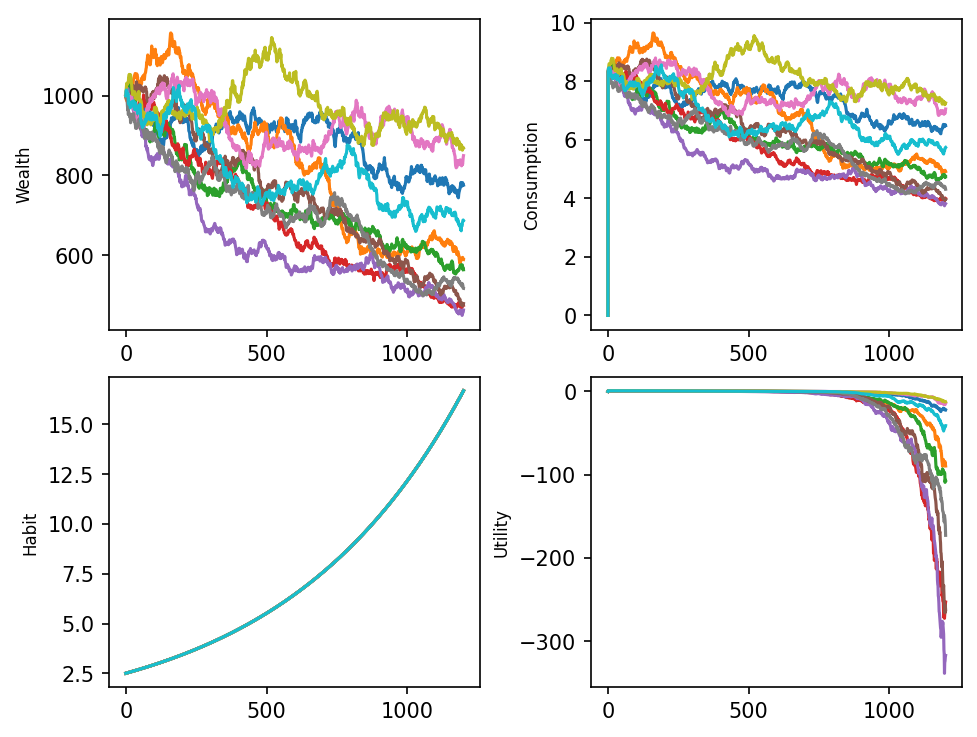

In [25]:
Number_Runs = 10

Total_Return_list = []

fig, axs = plt.subplots(nrows = 2, ncols = 2, layout='constrained', dpi=150)

for i in range(Number_Runs):
    df = Info_to_DataFrame(env, model)
    
    axs[0,0].plot(df['Time'], df['Wealth_Out'])
    axs[0,1].plot(df['Time'], df['Consumption'])
    axs[1,0].plot(df['Time'], df['Habit_Out'])
    axs[1,1].plot(df['Time'], df['Utility'])

    Total_Return_list.append(df['Utility'].sum())
    
axs[0,0].set_ylabel('Wealth', fontsize = 8)
axs[0,1].set_ylabel('Consumption', fontsize = 8)
axs[1,0].set_ylabel('Habit', fontsize = 8)
axs[1,1].set_ylabel('Utility', fontsize = 8)

# axs[0,1].set_xlim([10,20])


Total_Return_list
Total_Return_array = np.array(Total_Return_list)
print('Average return:', Total_Return_array.mean())

plt.show()



<p style = "color:#e5ffe5; background:#680e19; text-align:center; font-size:18px; font-weight:600 ">  
    Plot the actions
</p>
Consumtion rate is the last entry in the action<br>

**Note**: The action provided by the step function, and even the predicted actions are not normalized.<br>
The normalized actions are found in the info provided by the step function.

In [26]:
min_wealth = 0
max_wealth = 1100

wealth_list = []
consumerate_list = []
shares_list = []

for i in range(min_wealth, max_wealth):
    action = model.predict((i,))
    wealth_list.append(i)
    consumerate_list.append(action[0][-1])
    shares_list.append(np.divide(action[0][0:-1], np.sum(action[0][0:-1])))


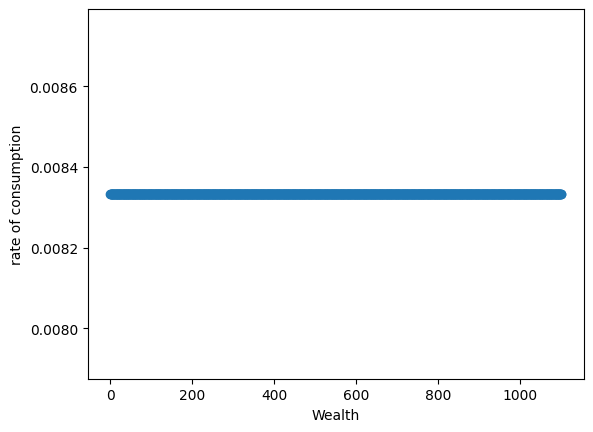

In [27]:
plt.scatter(wealth_list, consumerate_list)
plt.xlabel('Wealth')
plt.ylabel('rate of consumption')
plt.show()

In [28]:
import pandas as pd
df = pd.DataFrame(shares_list)
df.columns = ['Asset 1', 'Asset 2','Asset 3','Asset 4']
df['Wealth'] = pd.DataFrame(wealth_list)
df.tail()


,Asset 1,Asset 2,Asset 3,Asset 4,Wealth
1095,0.25,0.25,0.25,0.25,1095
1096,0.25,0.25,0.25,0.25,1096
1097,0.25,0.25,0.25,0.25,1097
1098,0.25,0.25,0.25,0.25,1098
1099,0.25,0.25,0.25,0.25,1099


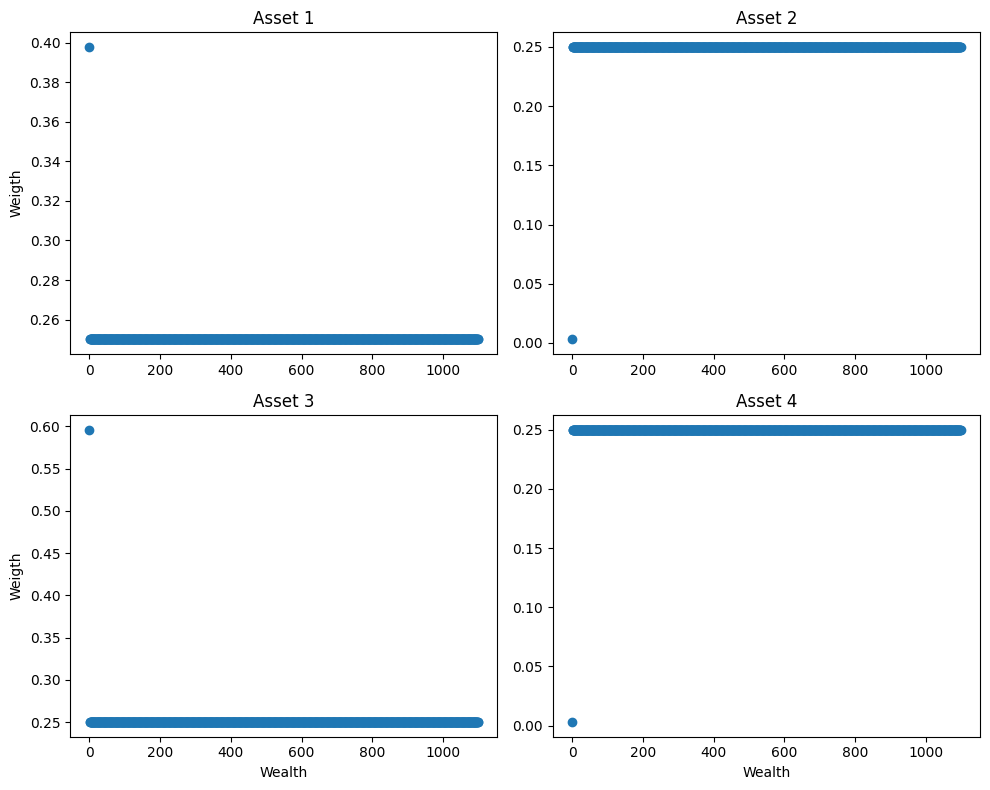

In [29]:
# Plotting
fig, axs = plt.subplots(2, 2, figsize=(10, 8))

# Plot variable 1 against wealth
axs[0, 0].scatter(df['Wealth'], df['Asset 1'])
axs[0, 0].set_title('Asset 1')
axs[0, 0].set_ylabel('Weigth')

# Plot variable B against E
axs[0, 1].scatter(df['Wealth'], df['Asset 2'])
axs[0, 1].set_title('Asset 2')

# Plot variable C against E
axs[1, 0].scatter(df['Wealth'], df['Asset 3'])
axs[1, 0].set_title('Asset 3')
axs[1, 0].set_ylabel('Weigth')
axs[1, 0].set_xlabel('Wealth')


# Plot variable D against E
axs[1, 1].scatter(df['Wealth'], df['Asset 4'])
axs[1, 1].set_title('Asset 4')
axs[1, 1].set_xlabel('Wealth')

plt.tight_layout()
plt.show()

<p style = "color:#FFFFFF; background:#f23b3b; text-align:center; font-size:18px; font-weight:600 ">  
    Plot from Tensorboard Log Files
</p>


In [ ]:
import tensorflow as tf
import tensorboard as tb
from tensorboard.backend.event_processing import event_accumulator
import matplotlib.pyplot as plt


In [ ]:
# Pathto your TensorBoard log directory
logdir = './Experiment_005/A2C/All_Tensorboards/Trial_2/A2C_0/'

In [ ]:
# Load TensorBoard events
event_acc = event_accumulator.EventAccumulator(logdir)
event_acc.Reload()

In [ ]:
# Get all scalar events
scalar_tags = event_acc.Tags()['scalars']
scalar_tags

In [ ]:
# Get all scalar events
scalar_events = event_acc.Scalars('rollout/ep_rew_mean')


In [ ]:
# Extract steps and values
steps = [event.step for event in scalar_events]
values = [event.value for event in scalar_events]

# Plot the data
plt.plot(steps, values)
plt.xlabel('Steps')
plt.ylabel('Value')
plt.title('Your Plot Title')
plt.grid(True)
plt.show()

In [ ]:
A = np.array([1,2,3,3,4,5,6])
B = np.array([1,1,4,3,5,2,1])

In [ ]:
Penalty = A > B
Penalty.astype(int)